In [36]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import stats, signal

import matplotlib.pyplot as plt
from pathlib import Path
import os
import sys

In [4]:
data_path = Path("D:\data_brain_to_text\competitionData")
train_path = data_path / "train"
test_path  = data_path / "test"
holdout_path = data_path / "competitionHoldOut"

fnames_train = os.listdir(train_path)
fnames_test = os.listdir(test_path)
fnames_holdout = os.listdir(holdout_path)

SFREQ = 50

In [5]:
data = loadmat(train_path / fnames_train[0])
np.unique(data['blockIdx'])

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8)

In [6]:
data = loadmat(test_path / fnames_test[0])
np.unique(data['blockIdx'])

array([17], dtype=uint8)

In [7]:
data = loadmat(holdout_path / fnames_holdout[0])
np.unique(data['blockIdx'])

array([1, 2], dtype=uint8)

In [8]:
for fname in fnames_train:
    fpath = train_path / fname
    data = loadmat(fpath)
    n_trials = data['blockIdx'].size
    print(f"File {fname}: \n ")  
    total_timepoints = 0
    for trial in range(n_trials):
        total_timepoints += data['spikePow'][0, trial].shape[0]
        
    print(f"# trials = {n_trials}; # timepoints = {total_timepoints / 1000:.0f} 000")
    print(f"Average trial length = {total_timepoints / n_trials / SFREQ:.0f} sec ({total_timepoints / n_trials:.0f}) points \n")

File t12.2022.04.28.mat: 
 
# trials = 280; # timepoints = 158 000
Average trial length = 11 sec (566) points 

File t12.2022.05.05.mat: 
 
# trials = 360; # timepoints = 183 000
Average trial length = 10 sec (507) points 

File t12.2022.05.17.mat: 
 
# trials = 420; # timepoints = 153 000
Average trial length = 7 sec (365) points 

File t12.2022.05.19.mat: 
 
# trials = 180; # timepoints = 64 000
Average trial length = 7 sec (355) points 

File t12.2022.05.24.mat: 
 
# trials = 360; # timepoints = 116 000
Average trial length = 6 sec (322) points 

File t12.2022.05.26.mat: 
 
# trials = 360; # timepoints = 124 000
Average trial length = 7 sec (345) points 

File t12.2022.06.02.mat: 
 
# trials = 400; # timepoints = 118 000
Average trial length = 6 sec (295) points 

File t12.2022.06.07.mat: 
 
# trials = 360; # timepoints = 105 000
Average trial length = 6 sec (292) points 

File t12.2022.06.14.mat: 
 
# trials = 320; # timepoints = 103 000
Average trial length = 6 sec (323) points 



The moisture in my eyes is from eyedrops, not from tears.                             


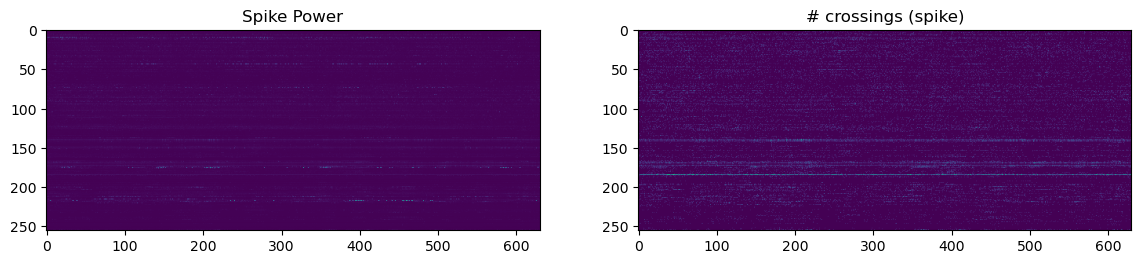

In [9]:
i_file = 0
i_trial = 50

fname = fnames_train[i_file]
fpath = train_path / fname

data = loadmat(fpath)
spikePow = data['spikePow']
tx3 = data['tx3']
tx1 = data['tx1']

print(data['sentenceText'][i_trial])

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

ax = axes[0]
ax.imshow(spikePow[0, i_trial].T)
ax.set_title("Spike Power")

ax = axes[1]
ax.imshow(tx3[0, i_trial].T)
ax.set_title("# crossings (spike)");

In [30]:
tx3[0, i_trial].shape

(389, 256)

The moisture in my eyes is from eyedrops, not from tears.                             


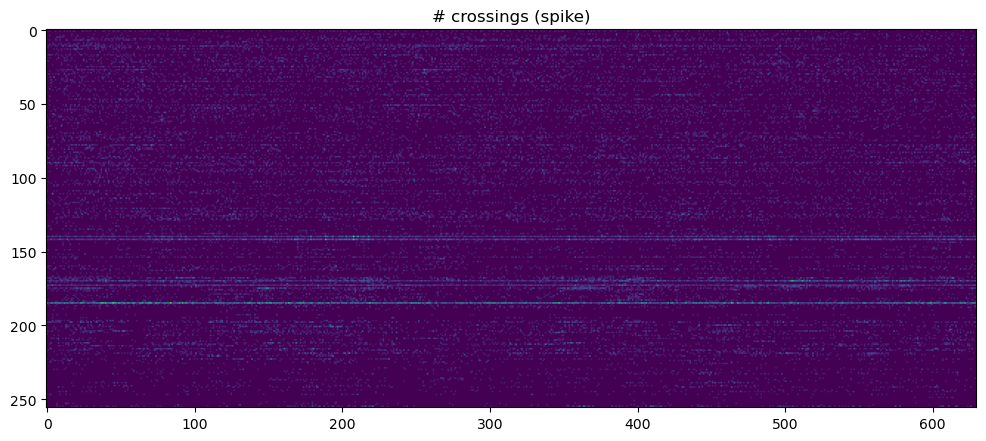

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.set_title("# crossings (spike)");
ax.imshow(tx3[0, i_trial].T)

print(data['sentenceText'][i_trial])

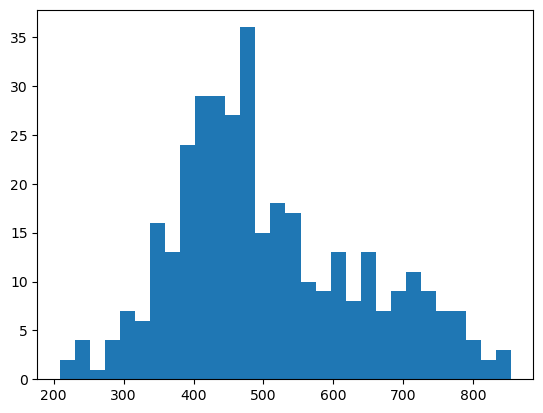

In [15]:
i_file = 1
fname = fnames_train[i_file]
fpath = train_path / fname
data = loadmat(fpath)

n_trials = data['blockIdx'].size
spikePow = data['spikePow']
tx3 = data['tx3']
lengths = []
for i_trial in range(n_trials):
    
    lengths.append(spikePow[0, i_trial].shape[0])
    
plt.hist(lengths, bins=30);

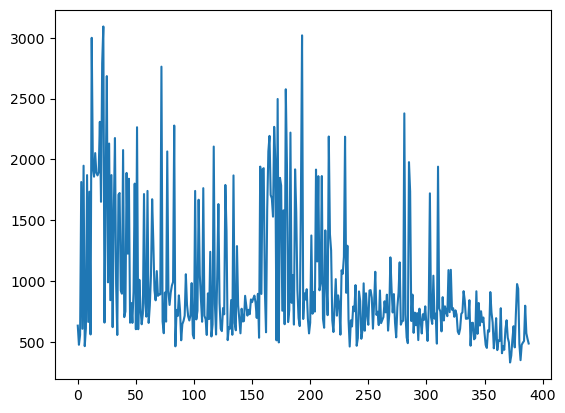

In [12]:
i_chan = 10
plt.plot(spikePow[0, i_trial][:, i_chan])

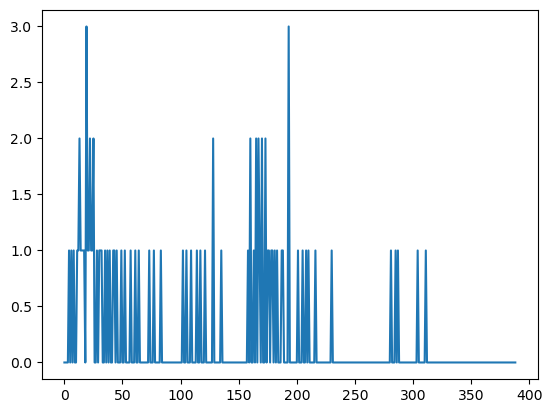

In [16]:
i_chan = 10
plt.plot(tx3[0, i_trial][:, i_chan])

In [85]:
def process_signal(voltage_list, spikes_list, block_list):
    """
    Preprocess voltages / spike counts based on the
    block-consistent features (z-score)
    """
    
    n_trials = len(block_list)
    trial_indices = np.arange(n_trials)
    
    """ Concatenate spikes and voltages """
    # concatenate spike power and threshold crossings along the channels dimension
    
    brain_concat = np.empty(n_trials, dtype=object)
    for i in range(n_trials):
        brain_concat[i] = np.concatenate([voltage_list[i], spikes_list[i]], axis=1)
    
    """ Block-wise Z-score and smoothing """

    brain_processed = np.empty(n_trials, dtype=object)
    
    for block in np.unique(block_list):
        
        trial_mask = block_list == block
        
        brain_appended = np.concatenate(brain_concat[trial_mask], axis=0)
        
        # get row vectors because channels are 2nd dimension (column-wise means and stds)
        block_mean = brain_appended.mean(axis=0)[None, :] 
        block_std  = brain_appended.std(axis=0)[None, :]
        
        block_std[block_std == 0] = 1
        
        # normalize each trial according to the block mean and std (zscore)
        for trial in trial_indices[trial_mask]:
            brain_processed[trial] = (brain_concat[trial] - block_mean) / block_std
            
            """ Gaussian smoothing over time (in the same loop for efficiency)"""
            # here we don't really care if it's causal (does not look into the future)
            # because we are decoding the whole sentence
            brain_processed[trial] = scipy.ndimage.gaussian_filter1d(brain_processed[trial], sigma=1, axis=0)            
            
    return brain_processed

def process_text(arr):
    return [str.strip() for str in arr]

def process_file(data_file):
    
    data = scipy.io.loadmat(data_file)
    date = data_file.stem

    n_trials = data['blockIdx'].shape[0]

    date_list = [date for _ in range(n_trials)]

    voltage_list = data['spikePow'][0][:]
    spikes_list  = data['tx4'][0][:]
    block_list   = data['blockIdx'][:, 0]

    brain_list = process_signal(voltage_list, spikes_list, block_list)
    
    sentence_list = data['sentenceText']
    sentence_list = process_text(sentence_list)

    return brain_list, sentence_list, date_list


def process_all_files(path):
    
    data_res = {'brain_list':[], 'sentence_list':[], 'date_list':[]}
    
    for data_file in sorted(path.glob('*.mat')):

        brains, sentences, dates = process_file(data_file)
        
        data_res['brain_list'].extend(brains)
        data_res['sentence_list'].extend(sentences)
        data_res['date_list'].extend(dates)

    return data_res

In [83]:
X, y, dates = process_file(train_path / fnames_train[0])

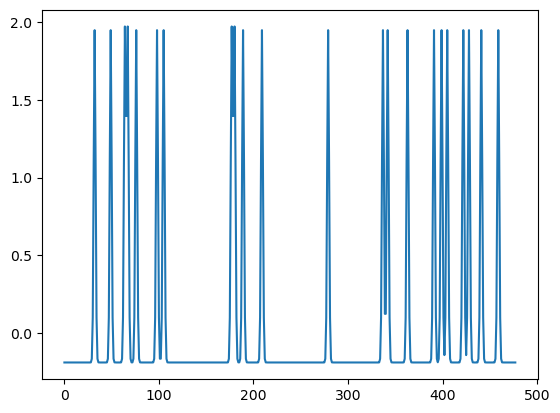

In [84]:
i_trial = 0
i_chan = 270

plt.plot(X[i_trial][:, i_chan])

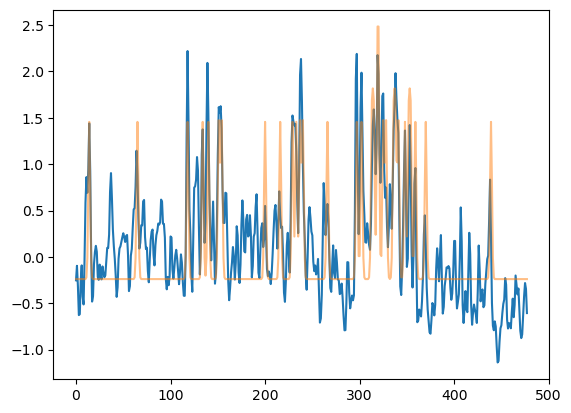

In [91]:
X, y, dates = process_file(train_path / fnames_train[0])

i_trial = 0
i_chan = 5

plt.plot(X[i_trial][:, i_chan])
plt.plot(X[i_trial][:, i_chan + 256], alpha=0.5)

In [78]:
y[i_trial]

'Nuclear rockets can destroy airfields with ease.'

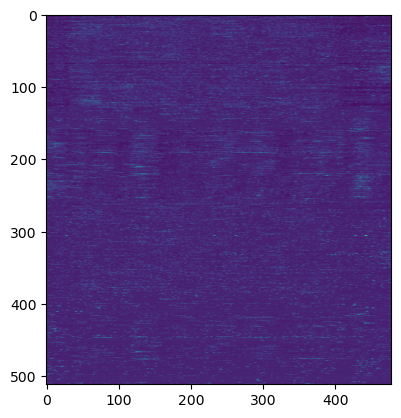

In [79]:
plt.imshow(X[i_trial].T)

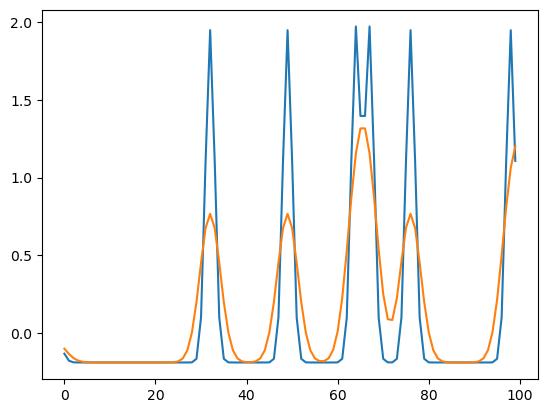

In [81]:
pad_begin = 8
pad_end = 0
n_times = 100
sigma = 2 # 40 ms

sig_orig = X[i_trial][:n_times, i_chan]
sig_padded = np.pad(sig_orig, pad_width=[(pad_begin, pad_end)])
sig_smoothed = scipy.ndimage.gaussian_filter1d(sig_padded, sigma=2)

plt.plot(sig_orig)
#plt.plot(sig_padded)
plt.plot(sig_smoothed[pad_begin:])